In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from torch.utils import data
import torch
import os
from from_scratch.dataset import Dataset, resize
from from_scratch.losses import ComputeLoss
from from_scratch.model import Yolo

In [2]:
dataset = Dataset('/home/davide/Desktop/change_detection/dataset', input_size=640)
train_loader = data.DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True, collate_fn=Dataset.collate_fn)
print(f"Train_loader: {len(train_loader)} batches")
batch = next(iter(train_loader))
print("All keys in batch: ", batch[1].keys())
print(f"Input batch shape: ", batch[0].shape)
print(f"Classification scores: {batch[1]['cls'].shape}")
print(f"Box coordinates: {batch[1]['box'].shape}")
print(f"Index identifier (which score belongs to which image): {batch[1]['idx'].shape}")


Train_loader: 4 batches
All keys in batch:  dict_keys(['cls', 'box', 'idx'])
Input batch shape:  torch.Size([32, 1, 640, 640])
Classification scores: torch.Size([135, 1])
Box coordinates: torch.Size([135, 4])
Index identifier (which score belongs to which image): torch.Size([135])


In [8]:
dataset = Dataset('/home/davide/Desktop/change_detection/dataset', input_size=640)
train_loader = data.DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True, collate_fn=Dataset.collate_fn)
print(f"Train_loader : {len(train_loader)} batches")

torch.manual_seed(42)

model = Yolo(version='n')
print(f"{sum(p.numel() for p in model.parameters())/1e6} million parameters")

criterion = ComputeLoss(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

num_epochs = 40

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, targets in train_loader:
        imgs = imgs.float()
        outputs = model(imgs)
        loss = sum(criterion(outputs, targets))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch : {epoch + 1} | avg loss : {epoch_loss / len(train_loader)}")

#torch.save(model.state_dict(), 'yolo_n.pth')

Train_loader : 4 batches
2.649366 million parameters


/home/davide/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch : 1 | avg loss : 197441.62890625


KeyboardInterrupt: 

In [ ]:
# saving checkpoint
#torch.save({
#    'epoch': 110,
#    'model_state_dict': model.state_dict(),
#    'optimizer_state_dict': optimizer.state_dict(),
#    'loss': epoch_loss / len(train_loader)
#}, 'yolo_n_checkpoint.pth')

# Load the model
model = Yolo(version='n')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
checkpoint = torch.load('yolo_n_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Loaded model from checkpoint at epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

Loaded model from checkpoint at epoch 100 with loss 8243.9795


In [16]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)
#criterion = ComputeLoss(model)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, targets in train_loader:
        imgs = imgs.float()
        outputs = model(imgs)
        loss = sum(criterion(outputs, targets))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch : {epoch + 1} | avg loss : {epoch_loss / len(train_loader)}")

Epoch : 1 | avg loss : 7142.005859375
Epoch : 2 | avg loss : 3695.2488403320312
Epoch : 3 | avg loss : 2018.395751953125
Epoch : 4 | avg loss : 1220.5402526855469
Epoch : 5 | avg loss : 841.8580169677734
Epoch : 6 | avg loss : 649.6039733886719
Epoch : 7 | avg loss : 508.1232452392578
Epoch : 8 | avg loss : 407.87896728515625
Epoch : 9 | avg loss : 339.9958038330078
Epoch : 10 | avg loss : 293.7027130126953


In [17]:
model.eval()
test_img = cv2.imread('/home/davide/Desktop/change_detection/dataset/images/val/186.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
h, w = test_img.shape
r = 640 / max(h, w)
if r != 1:
    test_img = cv2.resize(test_img, dsize=(int(w * r), int(h * r)), interpolation=cv2.INTER_LINEAR)
test_img, ratio, pad = resize(test_img, 640)
h, w = test_img.shape
test_img = test_img.reshape((1, 1, h, w))
test_img = np.ascontiguousarray(test_img)
test_img = torch.from_numpy(test_img)
with torch.no_grad():
    out186 = model(test_img.float())

model.eval()
test_img = cv2.imread('/home/davide/Desktop/change_detection/dataset/images/val/149.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
h, w = test_img.shape
r = 640 / max(h, w)
if r != 1:
    test_img = cv2.resize(test_img, dsize=(int(w * r), int(h * r)), interpolation=cv2.INTER_LINEAR)
test_img, ratio, pad = resize(test_img, 640)
h, w = test_img.shape
test_img = test_img.reshape((1, 1, h, w))
test_img = np.ascontiguousarray(test_img)
test_img = torch.from_numpy(test_img)
with torch.no_grad():
    out149 = model(test_img.float())

torch.sum(out186 == out149)

tensor(46491)

In [14]:
model.eval()
test_img = cv2.imread('/home/davide/Desktop/change_detection/dataset/images/val/186.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
h, w = test_img.shape
r = 640 / max(h, w)
if r != 1:
    test_img = cv2.resize(test_img, dsize=(int(w * r), int(h * r)), interpolation=cv2.INTER_LINEAR)
test_img, ratio, pad = resize(test_img, 640)
h, w = test_img.shape
test_img = test_img.reshape((1, 1, h, w))
test_img = np.ascontiguousarray(test_img)
test_img = torch.from_numpy(test_img)
with torch.no_grad():
    out = model(test_img.float())

(array([6400.,    0.,  400.,    0.,    0.,    0.,    0.,    0.,    0.,
        1600.]),
 array([0.4314386 , 0.44083375, 0.45022887, 0.45962399, 0.46901914,
        0.4784143 , 0.48780942, 0.49720454, 0.50659966, 0.51599485,
        0.52538997]),
 <BarContainer object of 10 artists>)

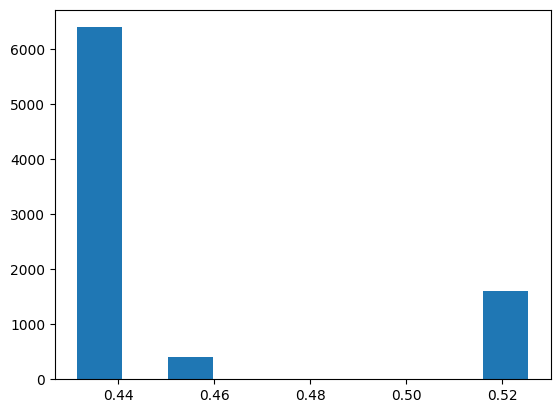

In [15]:
import matplotlib.pyplot as plt
plt.hist(np.array(out[0][4][:]))

In [16]:
out = out[0].T

boxes = out[:, :4]
confidences_0 = out[:, 4]
confidences_1 = out[:, 5]

scores = torch.maximum(confidences_0, confidences_1)
mask = scores > 0.2
boxes = boxes[mask]
scores = scores[mask]
confidences_0 = confidences_0[mask]
confidences_1 = confidences_1[mask]

boxes_xyxy = torch.zeros_like(boxes)
boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2
boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2
boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2
boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2
print(f"Boxes shape : {boxes_xyxy.shape}")
print(f"Scores shape : {scores.shape}")
print(f"Confidences 0 shape : {confidences_0.shape}")
print(f"Confidences 1 shape : {confidences_1.shape}")
import torchvision
keep = torchvision.ops.nms(boxes_xyxy, scores, iou_threshold=0.001)
boxes_xyxy = boxes_xyxy[keep]
scores = scores[keep]
confidences_0 = confidences_0[keep]
confidences_1 = confidences_1[keep]
keep.shape

Boxes shape : torch.Size([8400, 4])
Scores shape : torch.Size([8400])
Confidences 0 shape : torch.Size([8400])
Confidences 1 shape : torch.Size([8400])


torch.Size([8400])

In [22]:
out

tensor([[-0.0000, 0.0000, 0.0000, 0.0000, 0.4314, 0.5769],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4314, 0.5769],
        [0.0000, -0.0000, 0.0000, 0.0000, 0.4314, 0.5769],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4559, 0.3818],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4559, 0.3818],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4559, 0.3818]])

(array([107520.,      0.,      0.,    470.,   1269.,    734.,    576.,
           637.,    779., 297615.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

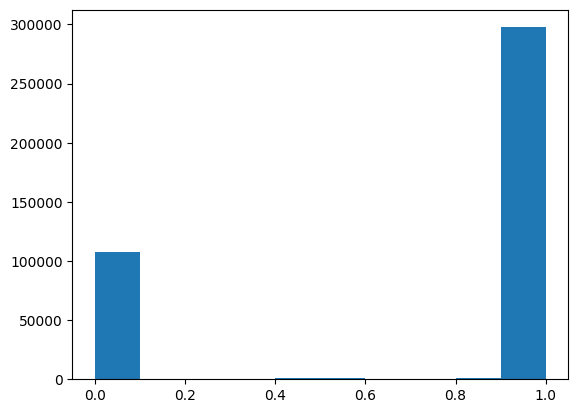

In [7]:
plt.hist(dataset.__getitem__(0)[0].reshape((640*640)).numpy())